Parsed with column specification:
cols(
  .default = col_double(),
  GeneSymbol = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  GeneSymbol = col_character()
)

See spec(...) for full column specifications.



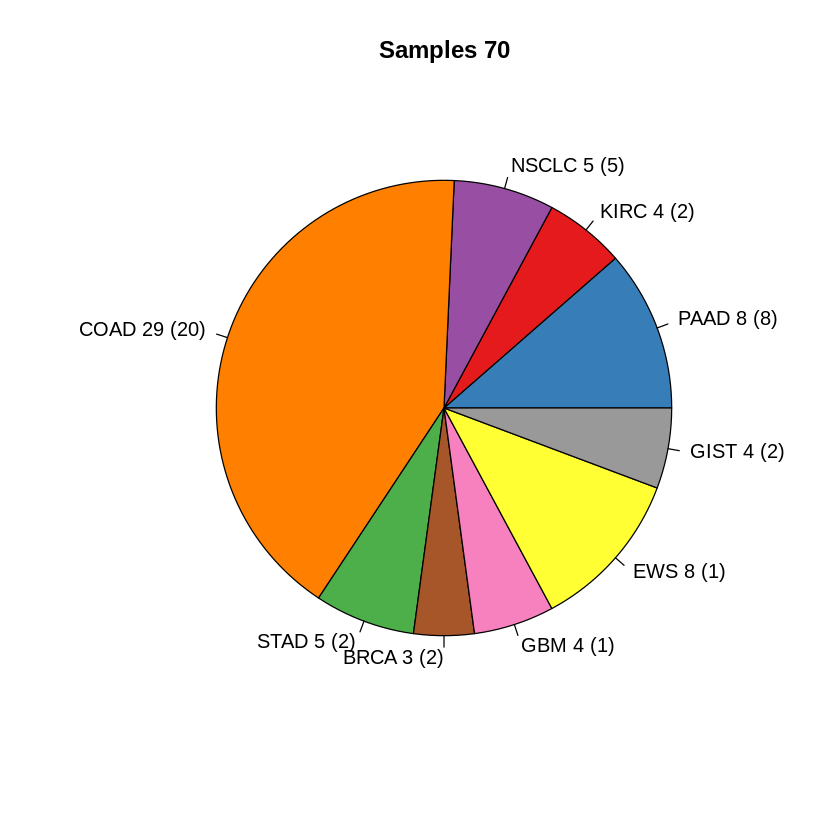

In [102]:
# Package requirement
mypkgs <- c("tidyverse", "edgeR", "RColorBrewer", "limma")
invisible(lapply(mypkgs, function(x){
    if(!do.call("require", list(x))){
        install.packages(x)
    }
}))

# Load expression data of Cancer (hg) / Stroma (mm) component of PDXs 
d.hg <- read.delim("../../data/PDX/Expression_matrix_CountEstimates_human.tsv", sep = "\t", row.names = 1)
d.mm <- read.delim("../../data/PDX/Expression_matrix_CountEstimates_mouse.tsv", sep = "\t", row.names = 1)

# Annotate samples and sort data
source("../../data/PDX/fn_anno_sort.R")
ls <- fn_anno_sort(d.hg, d.mm)
d.hg <- ls$d.hg
d.mm <- ls$d.mm
primary <- ls$primary
NXIDs <- ls$NXIDs
ann_colors <- ls$ann_colors

### sample Summary ###
num.primary <- summary(primary)
num.pass <- tapply(NXIDs, primary, function(x)sum(summary(unique(x))))
labels <- paste(names(num.primary), " ", num.primary, " (", num.pass, ")", sep = "")
pie(num.primary, labels = labels, main = paste("Samples", sum(num.primary)), col = ann_colors)

In [107]:
# lineaer modeling design
design <- model.matrix(~ 0 + primary); colnames(design) <- levels(primary)

# contrast matrix for comparison
cont.mat <- makeContrasts(
    KIRCvsOthers = KIRC - 1/8*(COAD+NSCLC+PAAD+STAD+BRCA+EWS+GBM+GIST),
              levels=design)
print("contrast matrix")
cont.mat

[1] "contrast matrix"


,KIRCvsOthers
PAAD,-0.125
KIRC,1.000
NSCLC,-0.125
COAD,-0.125
STAD,-0.125
BRCA,-0.125
GBM,-0.125
EWS,-0.125
GIST,-0.125


[1] "Original counts"


[1] 20000    70

[1] "Filtered counts"


[1] 17666    70

Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”


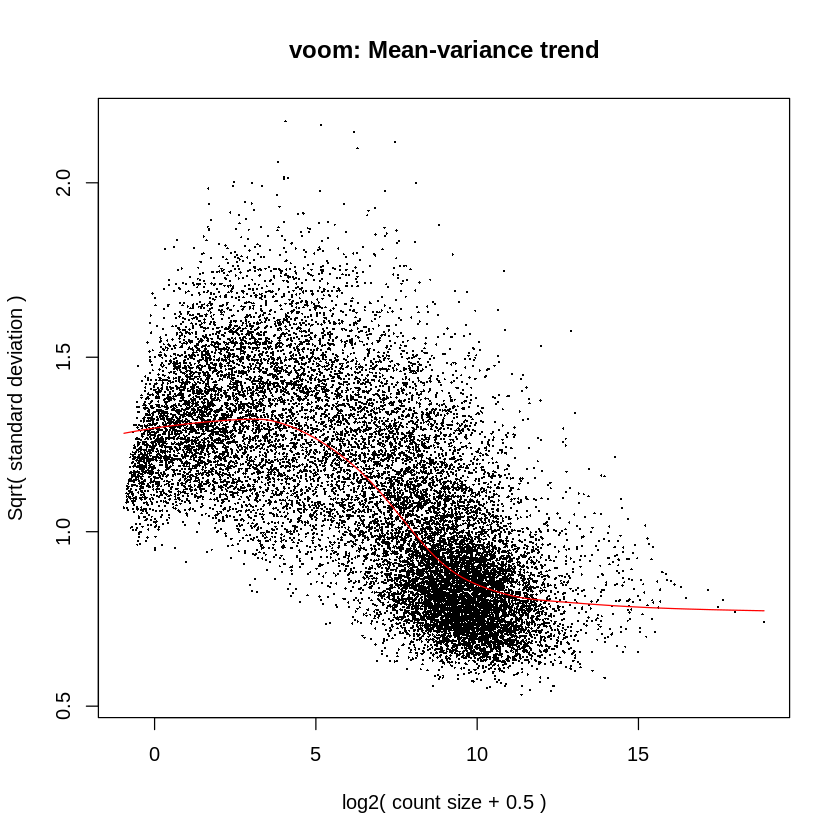

In [104]:
### hg ###
y.hg0 <- DGEList(d.hg)
# Filtering low expressed genes
y.hg0 <- calcNormFactors(y.hg0)
drop <- which(apply(cpm(y.hg0), 1, max) < 1) # Genes with TMM-normalized CPM < 1
y.hg <- y.hg0[-drop, ] # Values in this data are Count-estimates. NOT TMM-normalized CPM or TPM. 
print("Original counts"); dim(y.hg0)
print("Filtered counts"); dim(y.hg)

## mean-variance stabilization
v <- voom(y.hg, design, plot = T) # voom takes counts 
### passages => techinical duplicates
### intra-specimen (of the same NXID) correlation is incorporated into the covariance matrix
corfit <- duplicateCorrelation(v, design, block = NXIDs)
fit.hg <- lmFit(v, design, block=NXIDs, correlation=corfit$consensus)   ### model fitting


In [111]:

fit2.hg <- contrasts.fit(fit.hg, cont.mat)     # model fitting
fit2.hg <- eBayes(fit2.hg)    # empirical Bayes

test <- colnames(cont.mat)
print(test)
topTable(fit2.hg, adjust="fdr", number=Inf, sort.by = "P") %>% rownames_to_column("Gene") -> d.de.hg
write.table(d.de.hg, paste("../../suppl_tables/TableS6_DEG_", test, "_Cancer.tsv", sep=""), row.names = F, quote = F, sep = "\t")

[1] "KIRCvsOthers"


[1] "Original counts"


[1] 21895    70

[1] "Filtered counts"


[1] 17616    70

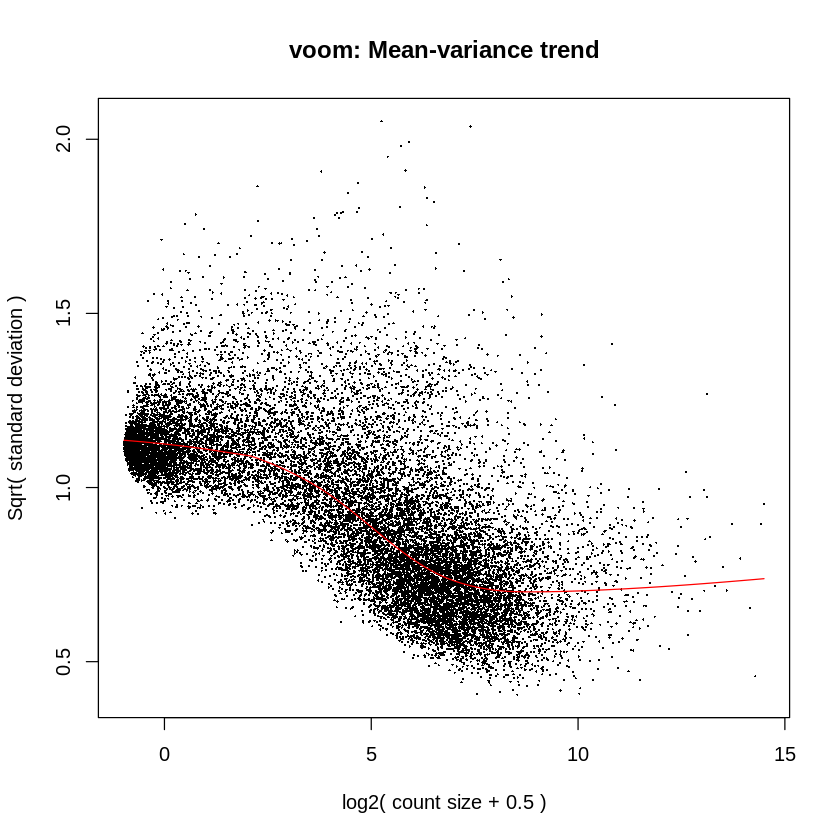

In [98]:
### mm ###
y.mm0 <- DGEList(d.mm)
# Filtering low expressed genes
y.mm0 <- calcNormFactors(y.mm0)
drop <- which(apply(cpm(y.mm0), 1, max) < 1)  # Genes with TMM-normalized CPM < 1
y.mm <- y.mm0[-drop, ] # Values in this data are Count-estimates. NOT CPM or TPM. 
print("Original counts"); dim(y.mm0)
print("Filtered counts"); dim(y.mm)

## mean-variance stabilization
v <- voom(y.mm, design, plot = T) # voom takes counts 
### passages => techinical duplicates
### intra-specimen (of the same NXID) correlation is incorporated into the covariance matrix
corfit <- duplicateCorrelation(v, design, block = NXIDs)
fit.mm <- lmFit(v, design, block=NXIDs, correlation=corfit$consensus)   ### model fitting

In [112]:
#
fit2.mm <- contrasts.fit(fit.mm, cont.mat)     # model fitting
fit2.mm <- eBayes(fit2.mm)    # empirical Bayes
test <- colnames(cont.mat)
print(test)
topTable(fit2.mm, adjust="fdr", number=Inf, sort.by = "P") %>% rownames_to_column("Gene") -> d.de.mm
write.table(d.de.mm, paste("../../suppl_tables/TableS4_DEG_", test, "_Stroma.tsv", sep=""), row.names = F, quote=F, sep = "\t")

[1] "KIRCvsOthers"
